# Genetic Programming

**Context**

This walkthrough will demonstrate genetic programming (GP) in DEAP. To do that we will address the 'odd parity' problem.

Parity is one of the classical GP problems. The input is an array of Boolean values. The solution should output a 'parity bit' of 1 if there are an even number of values, and a 0 otherwise. Usually 6 Boolean inputs are used (Parity-6), and the goal is to match the good parity bit value for each of the possible entries.



In [1]:
import operator
import pygraphviz as pgv
import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

# Training data generation

First we initialize the parity problem input and output (target) matrices

In [2]:
PARITY_FANIN_M = 6
PARITY_SIZE_M = 2**PARITY_FANIN_M

inputs = [None] * PARITY_SIZE_M
outputs = [None] * PARITY_SIZE_M

In [3]:
for i in range(PARITY_SIZE_M):
    inputs[i] = [None] * PARITY_FANIN_M
    value = i
    dividor = PARITY_SIZE_M
    parity = 1
    for j in range(PARITY_FANIN_M):
        dividor /= 2
        if value >= dividor:
            inputs[i][j] = 1
            parity = int(not parity)
            value -= dividor
        else:
            inputs[i][j] = 0
    outputs[i] = parity

Let's have a look at the training data that have been generated

In [4]:
len(inputs)

64

In [5]:
for i, o in zip(inputs, outputs):
    print(i, o)

[0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 1] 0
[0, 0, 0, 0, 1, 0] 0
[0, 0, 0, 0, 1, 1] 1
[0, 0, 0, 1, 0, 0] 0
[0, 0, 0, 1, 0, 1] 1
[0, 0, 0, 1, 1, 0] 1
[0, 0, 0, 1, 1, 1] 0
[0, 0, 1, 0, 0, 0] 0
[0, 0, 1, 0, 0, 1] 1
[0, 0, 1, 0, 1, 0] 1
[0, 0, 1, 0, 1, 1] 0
[0, 0, 1, 1, 0, 0] 1
[0, 0, 1, 1, 0, 1] 0
[0, 0, 1, 1, 1, 0] 0
[0, 0, 1, 1, 1, 1] 1
[0, 1, 0, 0, 0, 0] 0
[0, 1, 0, 0, 0, 1] 1
[0, 1, 0, 0, 1, 0] 1
[0, 1, 0, 0, 1, 1] 0
[0, 1, 0, 1, 0, 0] 1
[0, 1, 0, 1, 0, 1] 0
[0, 1, 0, 1, 1, 0] 0
[0, 1, 0, 1, 1, 1] 1
[0, 1, 1, 0, 0, 0] 1
[0, 1, 1, 0, 0, 1] 0
[0, 1, 1, 0, 1, 0] 0
[0, 1, 1, 0, 1, 1] 1
[0, 1, 1, 1, 0, 0] 0
[0, 1, 1, 1, 0, 1] 1
[0, 1, 1, 1, 1, 0] 1
[0, 1, 1, 1, 1, 1] 0
[1, 0, 0, 0, 0, 0] 0
[1, 0, 0, 0, 0, 1] 1
[1, 0, 0, 0, 1, 0] 1
[1, 0, 0, 0, 1, 1] 0
[1, 0, 0, 1, 0, 0] 1
[1, 0, 0, 1, 0, 1] 0
[1, 0, 0, 1, 1, 0] 0
[1, 0, 0, 1, 1, 1] 1
[1, 0, 1, 0, 0, 0] 1
[1, 0, 1, 0, 0, 1] 0
[1, 0, 1, 0, 1, 0] 0
[1, 0, 1, 0, 1, 1] 1
[1, 0, 1, 1, 0, 0] 0
[1, 0, 1, 1, 0, 1] 1
[1, 0, 1, 1, 1, 0] 1
[1, 0, 1, 1, 

# Setting up the algorithm

Our individual will be a function to which we will pass PARITY_FANIN_M values (here 6). As such, you need to define a primitive set that takes in that number of values. You would increase this if you wanted to pass more values, and have it at zero if your individual does not receive any arguments when it is executed.

In [7]:
# pset = gp.PrimitiveSet("MAIN", 0)
pset = gp.PrimitiveSet("MAIN", PARITY_FANIN_M, "IN")

By default input arguments are termed ARG0, ARG2 ... ARGi. We're fine with that here, but let's look at how to name the first argument ARG0 to x.

In [ ]:
# pset.renameArguments(ARG0='x')

# Now let's add some functions

We now register our functions and terminals. We would normally not know the function in advance, and might want to start with a limited set and then expand if needed.

In [8]:
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.xor, 2)
pset.addPrimitive(operator.not_, 1)
pset.addTerminal(1)
pset.addTerminal(0)

It's possible to use other functions, such as math ones, but we're limited to logic functions here.

In [ ]:
# pset.addPrimitive(operator.add, 2)
# pset.addPrimitive(operator.sub, 2)
# pset.addPrimitive(operator.mul, 2)
# pset.addPrimitive(protectedDiv, 2)
# pset.addPrimitive(operator.neg, 1)
# pset.addPrimitive(math.sin, 1)
# pset.addPrimitive(math.cos, 1)

You can also add an **ephemeral Constant**. The value of the constant is randomly initialised and then kept constant for a particular individual tree, but will differ from one Tree to another. Again, we do not need that here.

In [ ]:
# pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

Note that we have used lambda to create an anonymous function on the fly. This is so that we can define the arguments to randint to constrain it between -1 and 1.

In [9]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

The only real decision that you need to make when defining populations in the toolbox is what type of initialization you want to use. Individuals will always be of type toolbox.expr.

In [10]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5)

In [11]:
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [12]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

You might consider adding some limits on the height of any generated branch.

In [13]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=4))
toolbox.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5)
)

## Evaluation function

Provided below is the evaluation function that you should use.

In [14]:
def evalParity(individual):
    func = toolbox.compile(expr=individual)
    return (sum(func(*in_) == out for in_, out in zip(inputs, outputs)),)

In [15]:
toolbox.register("evaluate", evalParity)

## Register some stats

In [16]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

## Main algorithm

Before, you've always seen the full algorithm coded out. You can do the same here, but for brevity in this walkthrough I have used eaSimple.

In [17]:
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    cxpb=0.5,
    mutpb=0.1,
    ngen=150,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg	gen	max	min	nevals	std    	avg   	gen	max	min	nevals	std    
0  	500   	32 	0  	36 	28 	500   	0.45607	17.932	0  	59 	4  	500   	10.9396
1  	264   	32.066	1  	36 	32 	264   	0.426197	17.638	1  	59 	1  	264   	11.381 
2  	288   	32.082	2  	36 	31 	288   	0.378518	16.296	2  	54 	1  	288   	10.6908
3  	252   	32.186	3  	38 	30 	252   	0.606139	16.884	3  	54 	1  	252   	11.2039
4  	308   	32.37 	4  	38 	28 	308   	0.90835 	18.236	4  	54 	1  	308   	11.9379
5  	279   	32.7  	5  	38 	29 	279   	1.11445 	22.382	5  	56 	1  	279   	13.908 
6  	258   	33.168	6  	38 	28 	258   	1.28987 	25.726	6  	56 	1  	258   	13.1664
7  	282   	33.7  	7  	38 	28 	282   	1.59437 	26.98 	7  	54 	1  	282   	10.0985
8  	294   	34.482	8  	38 	28 	294   	1.77586 	27.768	8  	54 	1  	294   	7.

## Basic plots

In [18]:
import matplotlib.pyplot as plt

gen = log.chapters["fitness"].select("gen")
_min = log.chapters["fitness"].select("min")
_max = log.chapters["fitness"].select("max")
avgs = log.chapters["fitness"].select("avg")
stds = log.chapters["fitness"].select("std")

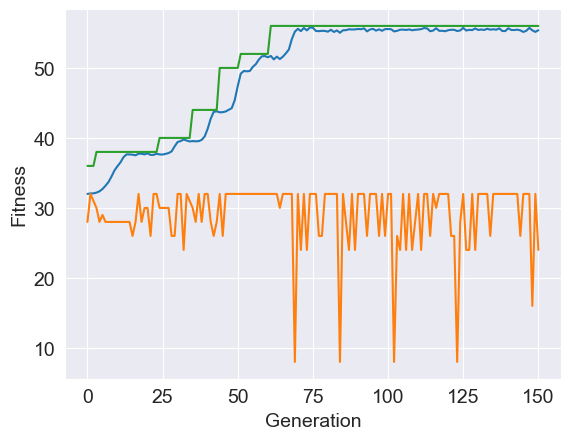

In [19]:
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)

Sometimes you might not be able to show the min and max on the same figure because of the scales.

Question: Why do you think the minimum is always so low?

## Let's examine our best individual

In [20]:
indv = tools.selBest(pop, 1)[0]
print(indv)

xor(and_(and_(or_(xor(IN2, IN3), not_(IN2)), or_(not_(IN1), xor(IN5, IN0))), xor(and_(IN5, not_(and_(IN5, IN1))), or_(xor(1, IN0), and_(IN0, IN1)))), not_(not_(xor(or_(IN3, IN2), IN4))))


In [21]:
nodes, edges, labels = gp.graph(indv)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

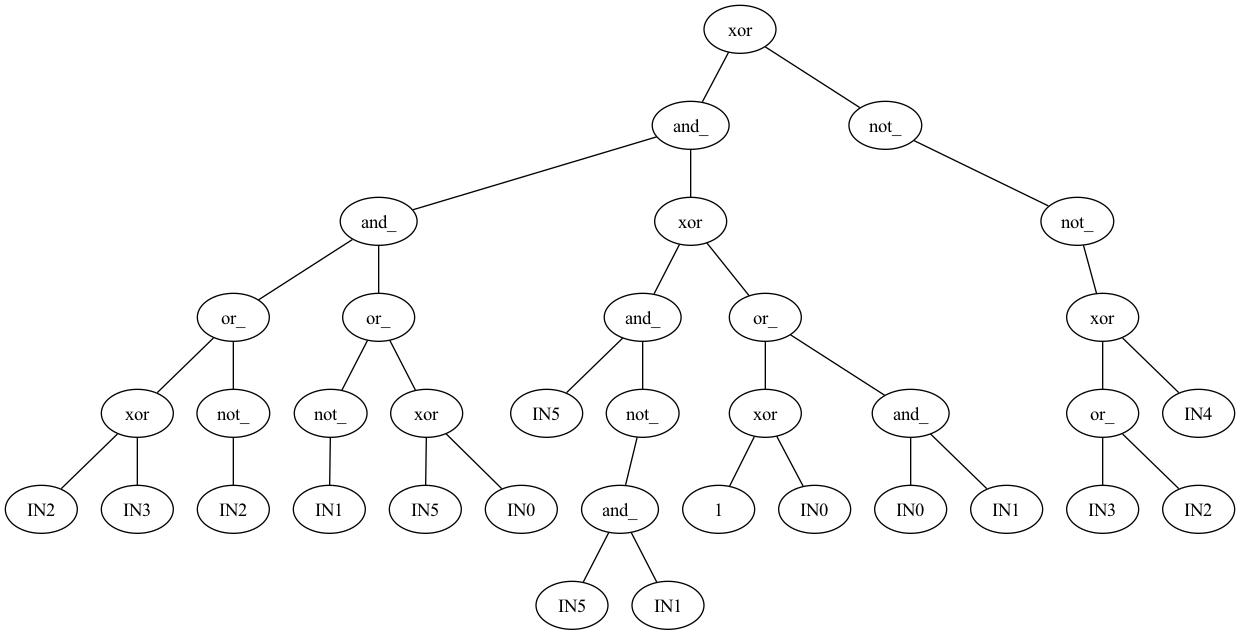

In [22]:
from IPython.display import Image

treePlot = tree.draw(format="png", prog="dot")
Image(treePlot)

In [23]:
toolbox.evaluate(indv)

(56,)